In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 入力ファイルの皆さん
T_FILES = [
    "../hdf/train_categorical.hdf",
    "../hdf/train_numeric.hdf",
    "../hdf/train_date_L0_normalized.hdf",
    "../hdf/train_date_L1_normalized.hdf",
    "../hdf/train_date_L2_normalized.hdf",
    "../hdf/train_date_L3_normalized.hdf",
    "../hdf/train_date_min_max.hdf",
    "../hdf/train_date_L0_min_max.hdf",
    "../hdf/train_date_L1_min_max.hdf",
    "../hdf/train_date_L2_min_max.hdf",
    "../hdf/train_date_L3_min_max.hdf",
    "../hdf/train_magic.hdf",
    "../hdf/train_id.hdf",
    "../hdf/train_categorical_L3_S32_F3854_decomposite.hdf",
    "../hdf/train_numeric_L1_S24_F1844_extract.hdf",
    "../hdf/train_numeric_L1_S24_F1723_-0.12.hdf",
    "../hdf/train_numeric_L1_S24_F1723_extract.hdf",
    "../hdf/train_mask.hdf",
    "../hdf/train_S_min_max.hdf",
    "../hdf/train_S_C_md5.hdf",
    "../hdf/train_S_N_md5.hdf",
]
RESPONSE = "../hdf/train_response.hdf"

In [3]:
def select_ccolumns(indices, file_list, remove_columns):
    print("Loading Train Data...")
    X = pd.concat((pd.read_hdf(filename).loc[indices]
                   for filename in file_list), axis=1)
    X.drop(remove_columns, axis=1, inplace=True)
    columns = X.columns
    y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()
    X = X.values
    # Feature Selection
    print("Selecting Train Features...")
    clf = XGBClassifier(base_score=0.005)
    clf.fit(X, y)
    tmp = [(clf.feature_importances_[i], columns[i])
           for i in range(len(columns))]
    tmp = sorted(tmp, reverse=True)
    columns = [c[1] for c in tmp]
    column_scores = [c[0] for c in tmp]

    return columns, column_scores


def xgboost_bosch(train_indices, train_file_list, important_columns):
    print("Reloading Train Data...")
    X = pd.concat(
        (drop_columns(
            pd.read_hdf(filename).loc[train_indices], important_columns)
         for filename in train_file_list),
        axis=1)
    y = pd.read_hdf(RESPONSE)
    y = y.loc[X.index].values.ravel()
    X = X.values
    # 予測して Cross Validation
    print("Predicting...")
    clf = XGBClassifier(max_depth=5, base_score=0.005)
    cv = StratifiedKFold(y, n_folds=3)
    predictions = np.ones(y.shape[0])
    for i, (train, test) in enumerate(cv):
        predictions[test] = clf.fit(X[train],
                                    y[train]).predict_proba(X[test])[:, 1]
        print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[
            test], predictions[test])))
    print(roc_auc_score(y, predictions))
    # MCC 最適化
    thresholds = np.linspace(0.01, 0.99, 200)
    mcc = np.array(
        [matthews_corrcoef(y, predictions > thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print(mcc.max())
    return clf, best_threshold


def drop_columns(df, undrop_columns):
    drop_columns = [c for c in df.columns if c not in undrop_columns]
    df.drop(drop_columns, axis=1, inplace=True)
    return df


def predict(important_columns, test_indices, clf, best_threshold,
            train_file_list):
    test_file_list = []
    for file in train_file_list:
        test_file_list.append(file.replace("train", "test"))
    # テストデータ読み込み
    print("Loading Test Data...")
    X = pd.concat(
        (drop_columns(pd.read_hdf(filename).loc[test_indices], important_columns)
         for filename in test_file_list),
        axis=1)
    X = X.values
    # 0 or 1 に正規化
    predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)
    # 提出データを生成
    sub = pd.DataFrame(index=test_indices.astype(np.int32), columns=[])
    sub["Response"] = predictions
    return sub

In [4]:
response = pd.read_hdf(RESPONSE)
ok_index = response[response["Response"] == 1.0].index
ng_index = response[response["Response"] ==
                    0.0].sample(n=len(ok_index) * 10).index
columns, column_scores = select_ccolumns(np.concatenate(
    [ok_index, ng_index]), T_FILES, remove_columns=["S32_C_md5", "S3_C_md5"])
[(c, s) for c, s in zip(columns, column_scores)]

Loading Train Data...
Selecting Train Features...


[('magic4', 0.084507041),
 ('magic3', 0.031298906),
 ('L3_S32_F3854', 0.028169014),
 ('L0_min', 0.026604069),
 ('min', 0.025039123),
 ('min_max', 0.021909233),
 ('S33_C_md5', 0.018779343),
 ('S2_C_md5', 0.017214397),
 ('L3_S30_F3704', 0.017214397),
 ('L3_S29_F3407', 0.014084507),
 ('L1_S24_F1844', 0.014084507),
 ('L1_S24_F1723', 0.014084507),
 ('L3_max', 0.012519562),
 ('L3_S29_F3339', 0.012519562),
 ('L0_S11_F322', 0.012519562),
 ('S2_C_md5', 0.010954617),
 ('L3_S33_F3865', 0.010954617),
 ('L3_S32_F3854_8', 0.010954617),
 ('L1_S24_F1846', 0.010954617),
 ('L1_S24_F1498', 0.010954617),
 ('L3_min', 0.0093896715),
 ('L3_S33_F3859', 0.0093896715),
 ('L3_S30_F3829', 0.0093896715),
 ('L2_S26_F3040', 0.0093896715),
 ('L1_S24_F1842', 0.0093896715),
 ('L0_S1_F28', 0.0093896715),
 ('max', 0.0078247264),
 ('L3_S34_D3875_normalized', 0.0078247264),
 ('L3_S30_F3754', 0.0078247264),
 ('L3_S30_F3709', 0.0078247264),
 ('L3_S30_F3589', 0.0078247264),
 ('L3_S30_F3554', 0.0078247264),
 ('L3_S30_F3544', 0

Reloading Train Data...
Predicting...
fold 0, ROC AUC: 0.893
fold 1, ROC AUC: 0.860
fold 2, ROC AUC: 0.881
0.877268977612
0.612957456403


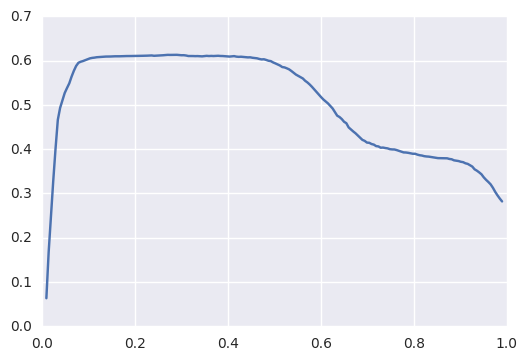

In [6]:
important_columns = [c for c, s in zip(columns, column_scores) if s > 0.005]
clf, best_threshold = xgboost_bosch(np.concatenate(
    [ok_index, ng_index]), T_FILES, important_columns)

In [7]:
test_index = pd.read_hdf("../hdf/test_date_min_max.hdf").index
sub = predict(important_columns, test_index, clf, best_threshold, T_FILES)
sub.to_csv("submission.csv.gz", compression="gzip")

Loading Test Data...


分割版

In [ ]:
def split_indices(train_df, test_df):
    train_index_list = []
    test_index_list = []

    md5_sum_S24_C_md5 = train_df.loc[[137]]["S24_C_md5"].values[0]
    train = train_df[train_df["S24_C_md5"] == md5_sum_S24_C_md5].index
    train_index_list.append(train)
    train_df.drop(train, inplace=True)
    test = test_df[test_df["S24_C_md5"] == md5_sum_S24_C_md5].index
    test_index_list.append(test)
    test_df.drop(test, inplace=True)

    md5_sum_S24_C_md5 = train_df.loc[[16]]["S24_C_md5"].values[0]
    train = train_df[train_df["S24_C_md5"] == md5_sum_S24_C_md5].index
    train_index_list.append(train)
    train_df.drop(train, inplace=True)
    test = test_df[test_df["S24_C_md5"] == md5_sum_S24_C_md5].index
    test_index_list.append(test)
    test_df.drop(test, inplace=True)

    train_index_list.append(train_df.index)
    test_index_list.append(test_df.index)
    return train_index_list, test_index_list

In [ ]:
pre = ["../hdf/train_S_C_md5.hdf", "../hdf/train_mask.hdf"]
tr = pd.concat((pd.read_hdf(filename) for filename in pre), axis=1)
te = pd.concat((pd.read_hdf(f.replace("train", "test")) for f in pre), axis=1)
train_index_list, test_index_list = split_indices(tr, te)
train_index_list, test_index_list

In [ ]:
subs = []
for i in range(len(train_index_list)):
    important_columns, clf, best_threshold = xgboost_bosch(train_index_list[i], T_FILES)
    sub = predict(important_columns, test_index_list[i], clf, best_threshold, T_FILES)
    subs.append(sub)

In [ ]:
pd.concat(subs).to_csv("submission.csv.gz", compression="gzip")

In [ ]:
xgboost_bosch(
    pd.DataFrame(
        index=train_index_list[2], columns=[]).sample(n=600000).index,
    T_FILES)